# Model Deployment

We will use this notebook to deploy our XGBoost model to sagemaker model store and configure an endpoint to access it from.

## Imports

In [46]:
# Standard libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from time import gmtime, strftime, time

import warnings
warnings.filterwarnings('ignore')

#sklearn 
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_recall_curve, auc, precision_score, recall_score

# Sagemaker imports
import boto3
import sagemaker

In [2]:
role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = sess.boto_region_name

bucket = sess.default_bucket()
prefix = "yelp-business-risk-predictor-XGBoost"

In [3]:
s3 = boto3.client("s3")
sm = boto3.client("sagemaker")

In [4]:
df = pd.read_csv("./training_data/split_dataset.csv")

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSplit counts:\n", df["split"].value_counts(dropna=False))
print("\nTarget counts:\n", df["is_highly_rated"].value_counts(dropna=False))

Shape: (10000, 20)

Columns: ['business_id', 'stars', 'review_count', 'parking_availability_score', 'enhanced_parking_score', 'has_parking', 'price_range', 'total_reviews', 'avg_review_stars', 'review_engagement', 'rating_consistency', 'is_restaurant', 'parking_mentions', 'parking_positive_sentiment', 'parking_negative_sentiment', 'free_parking_mentions', 'valet_mentions', 'has_good_parking', 'is_highly_rated', 'split']

Split counts:
 split
train    4025
prod     3984
val      1003
test      988
Name: count, dtype: int64

Target counts:
 is_highly_rated
0    6330
1    3670
Name: count, dtype: int64


In [5]:
# Ensure target is integer
df["is_highly_rated"] = df["is_highly_rated"].astype(int)

# Remove duplicates if any
df = df.drop_duplicates()

TARGET = "is_highly_rated"
NON_FEATURES = ["business_id", "split", TARGET]
IGNORED_FEATURES = [
    "stars",
    "avg_review_stars",
    "total_reviews",
    "review_count",
    "rating_consistency",
    "review_engagement"
]

FEATURES = [c for c in df.columns if c not in (NON_FEATURES + IGNORED_FEATURES)]

for c in FEATURES:
    df[c] = pd.to_numeric(df[c], errors="coerce")

print("\nExample rows:\n")
display(df.head(3))


Example rows:



,business_id,stars,review_count,parking_availability_score,enhanced_parking_score,has_parking,price_range,total_reviews,avg_review_stars,review_engagement,rating_consistency,is_restaurant,parking_mentions,parking_positive_sentiment,parking_negative_sentiment,free_parking_mentions,valet_mentions,has_good_parking,is_highly_rated,split
0,71U7MxQEhwitJOm4CQpRwQ,4.0,325,2,2.5,1,2.0,345,3.881159,1.440580,1.666667,1,14,0,0,0,0,0,0,prod
1,qEzhExWx4nogW_0B5JfUCw,3.5,99,2,2.5,1,1.0,104,3.567308,1.153846,1.666667,1,18,0,0,0,0,0,0,prod
2,z0SRVH4OpDQxgf2-m_wcZg,3.5,68,2,2.5,1,1.0,71,3.436620,1.521127,1.666667,1,14,0,0,0,0,0,0,train


In [6]:
found_splits = set(df["split"].astype(str).str.lower().unique())
print("Found splits:", found_splits)

Found splits: {'train', 'prod', 'test', 'val'}


In [7]:
# Create partitions
train = df[df["split"] == "train"].drop(["business_id"], axis=1)
val = df[df["split"] == "val"].drop(["business_id"], axis=1)
test = df[df["split"] == "test"].drop(["business_id"], axis=1)
prod = df[df["split"] == "prod"].drop([TARGET], axis=1)
prod_no_id = prod.drop(["business_id"], axis=1)

print(f"\nTraining rows: {len(train)}\n Validation rows: {len(val)}\n Test rows: {len(test)}\n Production rows: {len(prod)}")


Training rows: 4025
 Validation rows: 1003
 Test rows: 988
 Production rows: 3984


In [8]:
train_out = train[[TARGET] + FEATURES]
val_out   = val[[TARGET] + FEATURES]
test_out  = test[[TARGET] + FEATURES]
prod_out = prod[FEATURES]
prod_no_id_out = prod_no_id[FEATURES]

In [9]:
# Handle class imbalance
neg = (train_out[TARGET] == 0).sum()
pos = (train_out[TARGET]  == 1).sum()
scale_pos_weight = neg / max(pos, 1)

print(f"Class balance -> neg: {neg}, pos: {pos}, scale_pos_weight: {scale_pos_weight:.2f}")

Class balance -> neg: 2555, pos: 1470, scale_pos_weight: 1.74


In [12]:
local_dir_prefix = "data/"

train_file = "train_data.csv"
train_out.to_csv(local_dir_prefix+train_file, index=False, header=False)
sess.upload_data(local_dir_prefix+train_file, key_prefix="{}/train".format(prefix))

validation_file = "validation_data.csv"
val_out.to_csv(local_dir_prefix+validation_file, index=False, header=False)
sess.upload_data(local_dir_prefix+validation_file, key_prefix="{}/validation".format(prefix))

test_file = "test_data.csv"
test_out.to_csv(local_dir_prefix+test_file, index=False, header=False)
sess.upload_data(local_dir_prefix+test_file, key_prefix="{}/test".format(prefix))

prod_file = "prod_data.csv"
prod_out.to_csv(local_dir_prefix+prod_file, index=False, header=False)
sess.upload_data(local_dir_prefix+prod_file, key_prefix="{}/prod".format(prefix))

prod_file_no_id = "prod_data_no_id.csv"
prod_no_id_out.to_csv(local_dir_prefix+prod_file_no_id, index=False, header=False)
sess.upload_data(local_dir_prefix+prod_file_no_id, key_prefix="{}/prod".format(prefix))

's3://sagemaker-us-east-1-697347838118/yelp-business-risk-predictor-XGBoost/prod/prod_data_no_id.csv'

In [13]:
%%time

job_name = "xgb-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
output_location = "s3://{}/{}/output/{}".format(bucket, prefix, job_name)
image = sagemaker.image_uris.retrieve(
    framework="xgboost", region=boto3.Session().region_name, version="1.7-1"
)

INSTANCE_TYPE = "ml.m5.xlarge"
INSTANCE_COUNT = 1

sm_estimator = sagemaker.estimator.Estimator(
    image,
    role,
    instance_count=INSTANCE_COUNT,
    instance_type=INSTANCE_TYPE,
    volume_size=50,
    input_mode="File",
    output_path=output_location,
    sagemaker_session=sess,
)

sm_estimator.set_hyperparameters(
    early_stopping_rounds=50,
    objective="binary:logistic",
    max_depth=5,
    eta=0.05,
    eval_metric="auc",
    colsample_bytree=0.8,
    tree_method="hist",
    gamma=4,
    scale_pos_weight=scale_pos_weight,
    verbosity=0,
    num_round=300,
    seed=5406,
    subsample=0.8
)

train_data = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train".format(bucket, prefix),
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
)
validation_data = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validation".format(bucket, prefix),
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
)

data_channels = {"train": train_data, "validation": validation_data}

# Start training by calling the fit method in the estimator
sm_estimator.fit(inputs=data_channels, job_name=job_name, logs=True)

INFO:sagemaker:Creating training-job with name: xgb-2026-01-31-20-04-34


2026-01-31 20:04:35 Starting - Starting the training job...
2026-01-31 20:04:49 Starting - Preparing the instances for training...
2026-01-31 20:05:37 Downloading - Downloading the training image......
2026-01-31 20:06:38 Training - Training image download completed. Training in progress.
2026-01-31 20:06:38 Uploading - Uploading generated training model/miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2026-01-31 20:06:33.642 ip-10-0-80-19.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2026-01-31 20:06:33.716 ip-10-0-80-19.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2026-01-31:20:06:34:INFO] Imported framework sagemaker_xgboost_container.tra

In [14]:
%%time

sm_transformer = sm_estimator.transformer(INSTANCE_COUNT, INSTANCE_TYPE)

# start a transform job
input_location = "s3://{}/{}/prod/{}".format(
    bucket, prefix, prod_file_no_id
)  # use input data without ID column
sm_transformer.transform(input_location, content_type="text/csv", split_type="Line")
sm_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2026-01-31-20-07-38-761
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2026-01-31-20-07-39-571


............................/miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2026-01-31:20:12:21:INFO] No GPUs detected (normal if no gpus installed)
[2026-01-31:20:12:21:INFO] No GPUs detected (normal if no gpus installed)
[2026-01-31:20:12:21:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invoca

In [15]:
import re

def get_csv_output_from_s3(s3uri, batch_file):
    file_name = "{}.out".format(batch_file)
    match = re.match("s3://([^/]+)/(.*)", "{}/{}".format(s3uri, file_name))
    output_bucket, output_prefix = match.group(1), match.group(2)
    s3.download_file(output_bucket, output_prefix, file_name)
    return pd.read_csv(file_name, sep=",", header=None)

In [16]:
output_df = get_csv_output_from_s3(sm_transformer.output_path, prod_file_no_id)
output_df.head(8)

,0
0,0.423406
1,0.484773
2,0.617728
3,0.390622
4,0.575198
5,0.423406
6,0.618854
7,0.304397


In [17]:
# content_type / accept and split_type / assemble_with are required to use IO joining feature
sm_transformer.assemble_with = "Line"
sm_transformer.accept = "text/csv"

# start a transform job
input_location = "s3://{}/{}/prod/{}".format(
    bucket, prefix, prod_file
)  # use input data with ID column cause InputFilter will filter it out
sm_transformer.transform(
    input_location,
    split_type="Line",
    content_type="text/csv",
    input_filter="$[1:]",
    join_source="Input",
)
sm_transformer.wait()

INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2026-01-31-20-13-13-182


................................/miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2026-01-31:20:18:30:INFO] No GPUs detected (normal if no gpus installed)
[2026-01-31:20:18:30:INFO] No GPUs detected (normal if no gpus installed)
[2026-01-31:20:18:30:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nof

In [18]:
output_df = get_csv_output_from_s3(sm_transformer.output_path, "prod_data.csv")
output_df.head(8)

,0,1,2,3,4,5,6,7,8,9,10,11
0,2,2.5,1,2.0,1,14,0,0,0,0,0,0.451715
1,2,2.5,1,1.0,1,18,0,0,0,0,0,0.451715
2,1,1.5,1,2.0,1,7,0,0,0,0,0,0.581567
3,2,3.0,1,2.0,1,2,1,0,0,0,1,0.360123
4,3,4.0,1,2.0,1,18,2,0,0,0,1,0.373905
5,2,2.5,1,2.0,1,13,0,0,0,0,0,0.451715
6,2,2.0,1,NaN,1,4,0,0,0,0,0,0.451715
7,2,2.0,1,1.0,1,1,0,0,0,0,0,0.451715


In [19]:
%%time

# start another transform job
sm_transformer.transform(
    input_location,
    split_type="Line",
    content_type="text/csv",
    input_filter="$[1:]",
    join_source="Input",
    output_filter="$[0,-1]",
)
sm_transformer.wait()

INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2026-01-31-20-19-17-252


............................./miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2026-01-31:20:24:09:INFO] No GPUs detected (normal if no gpus installed)
[2026-01-31:20:24:09:INFO] No GPUs detected (normal if no gpus installed)
[2026-01-31:20:24:09:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invoc

In [20]:
output_df = get_csv_output_from_s3(sm_transformer.output_path, "prod_data.csv")
output_df.head(8)

,0,1
0,2,0.451715
1,2,0.451715
2,1,0.581567
3,2,0.360123
4,3,0.373905
5,2,0.451715
6,2,0.451715
7,2,0.451715


In [21]:
model_name = job_name
print(model_name)

info = sm.describe_training_job(TrainingJobName=model_name)
model_data = info["ModelArtifacts"]["S3ModelArtifacts"]

primary_container = {"Image": image, "ModelDataUrl": model_data}

# Save our model to the Sagemaker Model Registry
create_model_response = sm.create_model(
    ModelName=model_name, ExecutionRoleArn=role, PrimaryContainer=primary_container
)

print(create_model_response["ModelArn"])

xgb-2026-01-31-20-04-34
arn:aws:sagemaker:us-east-1:697347838118:model/xgb-2026-01-31-20-04-34


In [23]:
info

{'TrainingJobName': 'xgb-2026-01-31-20-04-34',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:697347838118:training-job/xgb-2026-01-31-20-04-34',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-697347838118/yelp-business-risk-predictor-XGBoost/output/xgb-2026-01-31-20-04-34/xgb-2026-01-31-20-04-34/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'colsample_bytree': '0.8',
  'early_stopping_rounds': '50',
  'eta': '0.05',
  'eval_metric': 'auc',
  'gamma': '4',
  'max_depth': '5',
  'num_round': '300',
  'objective': 'binary:logistic',
  'scale_pos_weight': '1.7380952380952381',
  'seed': '5406',
  'subsample': '0.8',
  'tree_method': 'hist',
  'verbosity': '0'},
 'AlgorithmSpecification': {'TrainingImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1',
  'TrainingInputMode': 'File',
  'MetricDefinitions': [{'Name': 'train:mae',
    'Regex': '.*\\[[0-9]+\\].*#011train-mae:([-+]?[0-

In [26]:
# Create Endpoint Configuration

# Create an endpoint config name. Here we create one based on the date
# so it we can search endpoints based on creation time.
endpoint_config_name = 'yelp-xgboost-endpoint-config' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,  # You will specify this name in a CreateEndpoint request.
    # List of ProductionVariant objects, one for each model that you want to host at this endpoint.
    ProductionVariants=[
        {
            "VariantName": "is-highly-rated-XGBoost",
            "ModelName": model_name, 
            "InstanceType": INSTANCE_TYPE,
            "InitialInstanceCount": INSTANCE_COUNT
        }
    ]
)

print(f"Created EndpointConfig: {endpoint_config_response['EndpointConfigArn']}")

Created EndpointConfig: arn:aws:sagemaker:us-east-1:697347838118:endpoint-config/yelp-xgboost-endpoint-config2026-01-31-20-28-28


In [28]:
# Deploy our model to real-time endpoint
endpoint_name = 'venue-signal-endpoint' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())


create_endpoint_response = sm.create_endpoint(
    EndpointName=endpoint_name, 
    EndpointConfigName=endpoint_config_name
) 

In [30]:
# Wait for endpoint to spin up

endpoint_res = sm.describe_endpoint(EndpointName=endpoint_name)

while True:
    print("Getting Job Status")
    res = sm.describe_endpoint(EndpointName=endpoint_name)
    state = res["EndpointStatus"]
    
    if state == "InService":
        print("Endpoint in Service")
        break
    elif state == "Creating":
        print("Endpoint still creating...")
        sleep(60)
    else:
        print("Endpoint Creation Error - Check Sagemaker Console")
        break

Getting Job Status
Endpoint in Service


In [31]:
sagemaker_runtime = boto3.client("sagemaker-runtime", region_name=region)

invoke_endpoint_response = sagemaker_runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType='text/csv',
    Body=prod_no_id_out.to_csv(header=None, index=False).strip('\n').split('\n')[0]
)
print(invoke_endpoint_response['Body'].read().decode('utf-8'))

0.42340558767318726



In [32]:
invoke_endpoint_response

{'ResponseMetadata': {'RequestId': '9d84328e-4d4c-4b5d-954f-101686cfab40',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '9d84328e-4d4c-4b5d-954f-101686cfab40',
   'x-amzn-invoked-production-variant': 'is-highly-rated-XGBoost',
   'date': 'Sat, 31 Jan 2026 20:36:54 GMT',
   'content-type': 'text/csv; charset=utf-8',
   'content-length': '20',
   'connection': 'keep-alive'},
  'RetryAttempts': 0},
 'ContentType': 'text/csv; charset=utf-8',
 'InvokedProductionVariant': 'is-highly-rated-XGBoost',
 'Body': <botocore.response.StreamingBody at 0x7f893d6876d0>}

In [68]:
sm.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '01a22073-10e8-4674-8789-d9eab9955236',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '01a22073-10e8-4674-8789-d9eab9955236',
   'strict-transport-security': 'max-age=47304000; includeSubDomains',
   'x-frame-options': 'DENY',
   'content-security-policy': "frame-ancestors 'none'",
   'cache-control': 'no-cache, no-store, must-revalidate',
   'x-content-type-options': 'nosniff',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 31 Jan 2026 21:37:48 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}

In [33]:
val_out_no_target = val_out[FEATURES].to_csv(header=None, index=False).strip('\n').split('\n')

body = ""
for row in val_out_no_target:
    body += row + "\n"

response = sagemaker_runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType='text/csv',
    Body=body
)

val_resp = response['Body'].read().decode('utf-8')

val_probs = []
for val in val_resp.split("\n")[:-1]:
    val_probs.append(float(val))

precision, recall, thresholds = precision_recall_curve(val_out[TARGET], val_probs)
pr_auc = auc(recall, precision)

print(f"Validation PR AUC: {pr_auc:.4f}")

Validation PR AUC: 0.5261


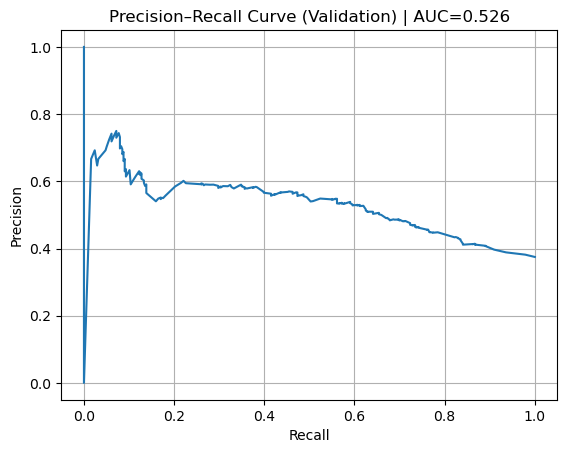

In [34]:
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (Validation) | AUC={pr_auc:.3f}")
plt.grid(True)
plt.show()

In [35]:
# Put into a table for inspection
pr_df = pd.DataFrame({
    "threshold": np.append(thresholds, 1.0),
    "precision": precision,
    "recall": recall
})

# Show some representative thresholds
pr_df.iloc[::max(len(pr_df)//10,1)].head(10)

,threshold,precision,recall
0,0.292926,0.374875,1.000000
29,0.420673,0.431535,0.829787
58,0.452905,0.481949,0.710106
87,0.489855,0.509677,0.630319
116,0.524092,0.536160,0.571809
145,0.546536,0.553892,0.492021
174,0.575198,0.558719,0.417553
203,0.602973,0.585859,0.308511
232,0.627325,0.548673,0.164894
261,0.680159,0.653846,0.090426


In [36]:
f1_scores = []
for t in thresholds:
    preds = (val_probs >= t).astype(int)
    f1_scores.append(f1_score(val_out[TARGET], preds))

best_t = thresholds[np.argmax(f1_scores)]
print(f"Best F1 threshold: {best_t:.3f}")

Best F1 threshold: 0.451


In [37]:
high_precision = pr_df[pr_df["precision"] >= 0.8]
high_precision.head()

,threshold,precision,recall
289,1.0,1.0,0.0


In [38]:
test_out_no_target = test_out[FEATURES].to_csv(header=None, index=False).strip('\n').split('\n')
body = ""
for row in test_out_no_target:
    body += row + "\n"

response = sagemaker_runtime.invoke_endpoint(
                            EndpointName=endpoint_name,
                            ContentType='text/csv',
                            Body=body
                            )
test_resp = response['Body'].read().decode('utf-8')

test_probs = []

for val in test_resp.split("\n")[:-1]:
    test_probs.append(float(val))

test_preds = (test_probs >= best_t).astype(int)

print("Confusion matrix:\n", confusion_matrix(test_out[TARGET], test_preds))
print("\nClassification report:\n")
print(classification_report(test_out[TARGET], test_preds, digits=3))

Confusion matrix:
 [[314 296]
 [113 265]]

Classification report:

              precision    recall  f1-score   support

           0      0.735     0.515     0.606       610
           1      0.472     0.701     0.564       378

    accuracy                          0.586       988
   macro avg      0.604     0.608     0.585       988
weighted avg      0.635     0.586     0.590       988



## Create Model Group

In [39]:
model_package_group_name = "venue-signal-is-highly-rated-model-group" + str(round(time()))
model_description = "venue signal model package group detects if a business will be highly rated based off of parking metadata"

model_package_group_input_dict = {
 "ModelPackageGroupName": model_package_group_name,
 "ModelPackageGroupDescription": model_description
}

create_model_package_group_response = sm.create_model_package_group(**model_package_group_input_dict)

print('ModelPackageGroup Arn : {}'.format(create_model_package_group_response['ModelPackageGroupArn']))

ModelPackageGroup Arn : arn:aws:sagemaker:us-east-1:697347838118:model-package-group/venue-signal-is-highly-rated-model-group1769891971


In [40]:
sm.describe_model_package_group(
    ModelPackageGroupName=model_package_group_name
)

{'ModelPackageGroupName': 'venue-signal-is-highly-rated-model-group1769891971',
 'ModelPackageGroupArn': 'arn:aws:sagemaker:us-east-1:697347838118:model-package-group/venue-signal-is-highly-rated-model-group1769891971',
 'ModelPackageGroupDescription': 'venue signal model package group detects if a business will be highly rated based off of parking metadata',
 'CreationTime': datetime.datetime(2026, 1, 31, 20, 39, 31, 96000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:697347838118:user-profile/d-ohmizsi7kzns/default-1768357685526',
  'UserProfileName': 'default-1768357685526',
  'DomainId': 'd-ohmizsi7kzns',
  'IamIdentity': {'Arn': 'arn:aws:sts::697347838118:assumed-role/LabRole/SageMaker',
   'PrincipalId': 'AROA2EXJLSCTAN3QBZ4ST:SageMaker'}},
 'ModelPackageGroupStatus': 'Completed',
 'ResponseMetadata': {'RequestId': '98fcc1ed-e6ac-44ad-9553-a548c0301387',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '98fcc1ed-e6ac-44ad-9553-a54

In [41]:
modelpackage_inference_specification = {
    "InferenceSpecification": {
        "Containers": [
             {
                "Image": image,
                "ModelDataUrl": info['ModelArtifacts']['S3ModelArtifacts'],
             }
        ],
        "SupportedContentTypes": ["text/csv"],
        "SupportedResponseMIMETypes": ["text/csv"],
        "SupportedTransformInstanceTypes": ["ml.m5.xlarge"],
    }
}

create_model_package_input_dict = {
    "ModelPackageGroupName": model_package_group_name,
    "ModelPackageDescription": model_description,
    "ModelApprovalStatus": "Approved"
}
create_model_package_input_dict.update(modelpackage_inference_specification)

In [42]:
create_model_package_response = sm.create_model_package(**create_model_package_input_dict)

model_package_arn = create_model_package_response["ModelPackageArn"]
print('ModelPackage Version ARN : {}'.format(model_package_arn))

ModelPackage Version ARN : arn:aws:sagemaker:us-east-1:697347838118:model-package/venue-signal-is-highly-rated-model-group1769891971/1


In [43]:
response = sm.describe_model_package(
    ModelPackageName=model_package_arn
)

response

{'ModelPackageGroupName': 'venue-signal-is-highly-rated-model-group1769891971',
 'ModelPackageVersion': 1,
 'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:697347838118:model-package/venue-signal-is-highly-rated-model-group1769891971/1',
 'ModelPackageDescription': 'venue signal model package group detects if a business will be highly rated based off of parking metadata',
 'CreationTime': datetime.datetime(2026, 1, 31, 20, 42, 49, 718000, tzinfo=tzlocal()),
 'InferenceSpecification': {'Containers': [{'Image': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1',
    'ImageDigest': 'sha256:b4f13edb198529c460692015797fa1ca6a8ff1ed64a149297174d922121b8fc4',
    'ModelDataUrl': 's3://sagemaker-us-east-1-697347838118/yelp-business-risk-predictor-XGBoost/output/xgb-2026-01-31-20-04-34/xgb-2026-01-31-20-04-34/output/model.tar.gz',
    'ModelDataETag': 'a4df62faf9cefeebea6edac72ddd268b'}],
  'SupportedTransformInstanceTypes': ['ml.m5.xlarge'],
  'SupportedContentTypes': ['tex

In [53]:
info

{'TrainingJobName': 'xgb-2026-01-31-20-04-34',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:697347838118:training-job/xgb-2026-01-31-20-04-34',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-697347838118/yelp-business-risk-predictor-XGBoost/output/xgb-2026-01-31-20-04-34/xgb-2026-01-31-20-04-34/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'colsample_bytree': '0.8',
  'early_stopping_rounds': '50',
  'eta': '0.05',
  'eval_metric': 'auc',
  'gamma': '4',
  'max_depth': '5',
  'num_round': '300',
  'objective': 'binary:logistic',
  'scale_pos_weight': '1.7380952380952381',
  'seed': '5406',
  'subsample': '0.8',
  'tree_method': 'hist',
  'verbosity': '0'},
 'AlgorithmSpecification': {'TrainingImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1',
  'TrainingInputMode': 'File',
  'MetricDefinitions': [{'Name': 'train:mae',
    'Regex': '.*\\[[0-9]+\\].*#011train-mae:([-+]?[0-

In [63]:
hyperparams = []
for k, v in info['HyperParameters'].items():
    hyperparams.append({"name": k, "value": v})

model_card_content = {
    "model_overview": {
        "model_description": model_description,
        "model_creator": "group 6",
        "model_artifact": [
            info["ModelArtifacts"]["S3ModelArtifacts"],
        ],
        "algorithm_type": "XGBoost (SageMaker built-in XGBoost container, binary:logistic objective)",
        "problem_type": "Binary classification (predict is_highly_rated)",
        "model_owner": "group 6",
    },
    "intended_uses": {
        "purpose_of_model": "Support business planning and risk assessment by estimating the likelihood that a business will be highly rated based on parking accessibility and parking-related signals extracted from business attributes and reviews.",
        "intended_uses": "Decision-support scoring for prospective location planning, operational planning, and exploratory analytics. Outputs can be used to rank businesses by predicted probability of high rating and group them into risk tiers (high, moderate, low, very low) for stakeholder interpretation.",
        "factors_affecting_model_efficiency": "Model performance depends on feature quality and consistency, especially parking-related indicators and sentiment counts. Predictions may degrade if feature definitions change, input distributions shift (new cities/categories), or review-derived features are missing or measured differently. The model does not incorporate non-parking drivers of ratings such as food/service quality, which limits achievable predictive performance.",
        "risk_rating": "Medium",
        "explanations_for_risk_rating": "Outputs may be used to inform business decisions. The model is trained on observational data and captures correlations rather than causal effects; misuse could lead to incorrect conclusions. Risk is mitigated by interpreting outputs as probabilistic signals and using risk tiers for guidance, not as definitive success/failure predictions.",
    },
    "business_details": {
        "business_problem": "When opening or evaluating business locations, stakeholders need to understand how parking constraints may impact customer satisfaction and ratings. Parking is a common source of friction that can affect demand and reviews, especially in dense or urban areas where parking availability is limited.",
        "business_stakeholders": "Business owners, investors, site selection teams, and operations teams evaluating location feasibility and mitigation strategies for parking constraints.",
        "line_of_business": "Hospitality / restaurants / local business analytics",
    },
    "training_details": {
        "objective_function": {
            "function": {
                "function": "Maximize",
                "facet": "auc",
                "condition": "validation",
            },
            "notes": "Optimized for validation AUC using binary:logistic objective. Early stopping was configured using the validation channel.",
        },
        "training_observations": "Early experiments showed unrealistically high validation performance due to leakage from rating-adjacent features (e.g., stars, avg_review_stars, review_count). These were removed to create a leak-free feature set focused on parking-related predictors.",
        "training_job_details": {
            "training_arn": info["TrainingJobArn"],
            "hyper_parameters": hyperparams,
            "training_datasets": [
                info["InputDataConfig"][0]["DataSource"]["S3DataSource"]["S3Uri"],
                info["InputDataConfig"][1]["DataSource"]["S3DataSource"]["S3Uri"],
            ],
            "training_environment": {
                "container_image": [
                    info["AlgorithmSpecification"]["TrainingImage"],
                ],
            },
            "training_metrics": [
                {
                    "name": info['FinalMetricDataList'][0]['MetricName'],
                    "value": info['FinalMetricDataList'][0]['Value'],
                },
                {
                    "name": info['FinalMetricDataList'][1]['MetricName'],
                    "value": info['FinalMetricDataList'][1]['Value'],
                }
            ],
        },
    },
    "additional_information": {
        "ethical_considerations": "The model is trained on user-generated reviews and derived signals, which may reflect social or geographic biases. Outputs should not be used to make high-stakes decisions about individuals or protected classes. Interpret predictions as probabilistic indicators of parking-related risk, not as definitive judgments of business quality.",
        "caveats_and_recommendations": "This model captures correlation, not causation; it cannot answer what would happen if parking were improved. Ratings are influenced by many factors not represented in the feature set (food quality, service, ambiance). Use the model as a risk signal alongside domain knowledge and additional features. Monitor for data drift if deployed across new regions or business categories.",
        "custom_details": {
            "feature_set_summary": "Parking-related features only; rating- and review-derived leakage features removed (stars, avg_review_stars, total_reviews, review_count, rating_consistency, review_engagement).",
            "deployment_notes": "For SageMaker built-in XGBoost CSV format, the label column must be the first column for training/validation/test channels.",
        },
    },
}

model_card_content_string = json.dumps(model_card_content, sort_keys=True, default=str)

In [64]:
model_card_name = "venue-signal-is-highly-rated-model-card-" + str(round(time()))

response = sm.create_model_card(
    ModelCardName=model_card_name,
    Content=model_card_content_string,
    ModelCardStatus='Approved',
)

response

{'ModelCardArn': 'arn:aws:sagemaker:us-east-1:697347838118:model-card/venue-signal-is-highly-rated-model-card-1769894360',
 'ResponseMetadata': {'RequestId': '878b1521-ebcc-47cc-9342-10b3801fc757',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '878b1521-ebcc-47cc-9342-10b3801fc757',
   'strict-transport-security': 'max-age=47304000; includeSubDomains',
   'x-frame-options': 'DENY',
   'content-security-policy': "frame-ancestors 'none'",
   'cache-control': 'no-cache, no-store, must-revalidate',
   'x-content-type-options': 'nosniff',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '121',
   'date': 'Sat, 31 Jan 2026 21:19:20 GMT'},
  'RetryAttempts': 0}}

In [66]:
response = sm.describe_model_card(
    ModelCardName=model_card_name,
)

response

{'ModelCardArn': 'arn:aws:sagemaker:us-east-1:697347838118:model-card/venue-signal-is-highly-rated-model-card-1769894360',
 'ModelCardName': 'venue-signal-is-highly-rated-model-card-1769894360',
 'ModelCardVersion': 1,
 'Content': '{"additional_information": {"caveats_and_recommendations": "This model captures correlation, not causation; it cannot answer what would happen if parking were improved. Ratings are influenced by many factors not represented in the feature set (food quality, service, ambiance). Use the model as a risk signal alongside domain knowledge and additional features. Monitor for data drift if deployed across new regions or business categories.", "custom_details": {"deployment_notes": "For SageMaker built-in XGBoost CSV format, the label column must be the first column for training/validation/test channels.", "feature_set_summary": "Parking-related features only; rating- and review-derived leakage features removed (stars, avg_review_stars, total_reviews, review_count,